## Overview
This notebook is used to generate various test vectors to support FALCON Digital Signal Processing unit tests. Vectors include: Finite Impulse Response (FIR) filter coefficients, raw complex input data, and raw complex output data.

## Constants
This notebook supports configurable behavior through environment variables, which in turn modify the notebook-level constants specified here.

In [58]:
from fractions import Fraction
import logging
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import os
from scipy import signal
import struct

In [60]:
FREQ_SHIFT_STR = os.environ.get('FREQ_SHIFT', '0')
INPUT_SAMPLE_RATE_STR = os.environ.get('INPUT_SAMPLE_RATE', '1000000')
OUTPUT_SAMPLE_RATE_STR = os.environ.get('OUTPUT_SAMPLE_RATE', '100000')
NUM_OUTPUT_SAMPLES_STR = os.environ.get('NUM_OUTPUT_SAMPLES', '10000')
VERBOSE_LOGGING_STR = os.environ.get('VERBOSE', '0')
OUTPUT_FILE_BASE_NAME = os.environ.get('OUT_FILE_NAME', 'polyphase_test_vector')
GENERATE_RAMP_FILE_STR = os.environ.get('RAMP_OUTPUT', '1')

# convert from the string environment variables to other, more convenient, representations
FREQ_SHIFT = np.array([FREQ_SHIFT_STR], dtype=np.float64)
INPUT_SAMPLE_RATE = np.array([INPUT_SAMPLE_RATE_STR], dtype=np.float64)
OUTPUT_SAMPLE_RATE = np.array([OUTPUT_SAMPLE_RATE_STR], dtype=np.float64)
NUM_OUTPUT_SAMPLES = int(NUM_OUTPUT_SAMPLES_STR)
GENERATE_RAMP_FILE = int(GENERATE_RAMP_FILE_STR)

INPUT_VEC_FILE_NAME = OUTPUT_FILE_BASE_NAME + "_x.bin"
OUTPUT_VEC_FILE_NAME = OUTPUT_FILE_BASE_NAME + "_y.bin"
FILTER_COEFFS_FILE_NAME = OUTPUT_FILE_BASE_NAME + ".filter_coeffs.txt"
    
VERBOSE_LOGGING = True
if VERBOSE_LOGGING_STR is not "1":
    VERBOSE_LOGGING = False

## Logging
Use the Python *logging* module for basic logging. Configure the logging level based on the provided command-line arguments.

In [61]:
logging_level = logging.INFO
if VERBOSE_LOGGING:
    logging_level = logging.DEBUG
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging_level)

In [62]:
logging.info("####################")
logging.info("# FREQ_SHIFT              = %f" % (FREQ_SHIFT))
logging.info("# INPUT_SAMPLE_RATE       = %f" % (INPUT_SAMPLE_RATE))
logging.info("# OUTPUT_SAMPLE_RATE      = %f" % (OUTPUT_SAMPLE_RATE))
logging.info("# NUM_OUTPUT_SAMPLES      = %u" % (NUM_OUTPUT_SAMPLES))
logging.info("# RAMP_OUTPUT             = %u" % (GENERATE_RAMP_FILE))
logging.info("# INPUT_FILE_NAME         = %s" % (INPUT_VEC_FILE_NAME))
logging.info("# OUTPUT_FILE_NAME        = %s" % (OUTPUT_VEC_FILE_NAME))
logging.info("# FILTER_COEFFS_FILE_NAME = %s" % (FILTER_COEFFS_FILE_NAME))
logging.info("####################")

INFO:####################
INFO:# FREQ_SHIFT              = 0.000000
INFO:# INPUT_SAMPLE_RATE       = 1000000.000000
INFO:# OUTPUT_SAMPLE_RATE      = 100000.000000
INFO:# NUM_OUTPUT_SAMPLES      = 10000
INFO:# RAMP_OUTPUT             = 1
INFO:# INPUT_FILE_NAME         = polyphase_test_vector_x.bin
INFO:# OUTPUT_FILE_NAME        = polyphase_test_vector_y.bin
INFO:# FILTER_COEFFS_FILE_NAME = polyphase_test_vector.filter_coeffs.txt
INFO:####################


## Design a Low Pass Filter
The objective is to use the *upfirdn* function so we need to convert the decimal resampling ratio into a fraction. From there, we can design a Finite Impulse Response (FIR) filter that meets our needs.

See the following excerpt from **Boaz Porat, A Course in Digital Signal Processing**:
> "The low-pass filter performs both interpolation of the expanded signal
    and antialiasing. If the sample rate is to be increased, then p > q. THe
    low pass filter should then have a cutoff frequency of pi/p. If the
    sampling rate is to be decreased, then p < q. The low-pass filter should
    then have a cutoff frequency pi/q. IN this case the filter will
    eliminate a part of the signals frequency contents of the original
    bandwidth if its original bandwidth is higher than pip/q. Thus, the
    sampling rate conversion filter should always have a cutoff frequency
    of pi/max{p,q}."

INFO:Input Sample Rate: 1000000 Hz
INFO:Output Sample Rate: 100000 Hz
INFO:Resampling Ratio 0.100000
INFO:Resampling Ratio: 1/10, pqmax=10
INFO:Cutoff Freq: 0.050000, Filter Order: 201 Filter Delay: 0
INFO:Write filter coefficients to polyphase_test_vector.filter_coeffs.txt


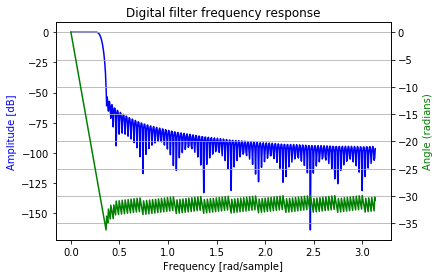

In [63]:
logging.info("Input Sample Rate: %d Hz" % (INPUT_SAMPLE_RATE))
logging.info("Output Sample Rate: %d Hz" % (OUTPUT_SAMPLE_RATE))

resampling_ratio = OUTPUT_SAMPLE_RATE / INPUT_SAMPLE_RATE
logging.info("Resampling Ratio %f" % (resampling_ratio))
ratio = Fraction("%.12f" % (resampling_ratio)).limit_denominator()
p = ratio.numerator
q = ratio.denominator
pqmax = max(p, q)
logging.info("Resampling Ratio: %d/%d, pqmax=%d" % (p, q, pqmax))

if int(p) != 1 or q != 1:

    # cutoff frequency of the lowpass filter at the high (upsampled) rate
    cutoff_freq = 1 / 2 / pqmax
    filter_order = 2 * 10 * pqmax + 1
    filter_delay = 0 # filtering is bypassed in this mode
    
else:
    
    # cutoff frequency of the lowpass filter at the high (upsampled) rate
    cutoff_freq = 0.25
    filter_order = 2 * 10 * pqmax + 1
    filter_delay = int((filter_order - 1) / p / 2)

logging.info("Cutoff Freq: %f, Filter Order: %u Filter Delay: %u" % (cutoff_freq, filter_order, filter_delay))

filter_coeffs = signal.firls(filter_order, [0, 2 * cutoff_freq, 2 * cutoff_freq, 1], [1, 1, 0, 0])
filter_coeffs = filter_coeffs * signal.kaiser(filter_order, beta=5)

filter_coeffs_file = open(FILTER_COEFFS_FILE_NAME, 'w')
for coeff in filter_coeffs:
    filter_coeffs_file.write("%0.12f %0.12f\n" % (coeff.real, coeff.imag))
    
filter_coeffs_file.close()

logging.info("Write filter coefficients to %s" % (FILTER_COEFFS_FILE_NAME))

# visualize the filter response
w, h = signal.freqz(filter_coeffs)
fig = plt.figure()
plt.title('Digital filter frequency response')
ax1 = fig.add_subplot(111)

plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [rad/sample]')

ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
plt.plot(w, angles, 'g')
plt.ylabel('Angle (radians)', color='g')
plt.grid()
plt.axis('tight')
plt.show()

## Create a Complex Sinusoid

In [64]:
## for fractional upsampling put the test tone closer to DC so that there
#  is more definition to the graphed original signal
us_test_tone_freq = (INPUT_SAMPLE_RATE * 0.3) / 2

# for fractional downsampling put the test tone at the outer edge of the
#  expected passband in order to verify that the filter is working
#  correctly and does not attenuate the input signal too badly
ds_test_tone_freq = (OUTPUT_SAMPLE_RATE * 0.4) / 2

# pick the minimum value
test_tone_freq = float(min(us_test_tone_freq, ds_test_tone_freq))

# adjust if we're not actually resampling
if p == 1 and q == 1:
    test_tone_freq = float(INPUT_SAMPLE_RATE * 0.1)

logging.info("Test tone freq=%u Hz" % (test_tone_freq))

SIGNAL_SCALE = 1024
NUM_INPUT_SAMPLES = int(NUM_OUTPUT_SAMPLES * q / p)
t = np.arange(0, NUM_INPUT_SAMPLES, dtype=np.float64)

if abs(FREQ_SHIFT) > 1:
    
    # compute an index, in floating point, which corresponds to a
    #  complete rotation
    rollover_idx_float = INPUT_SAMPLE_RATE / abs(FREQ_SHIFT)
    logging.info("Calculated float rollover index %.16f" % (rollover_idx_float))

    while rollover_idx_float < 1e5:
        rollover_idx_float = rollover_idx_float * 10.0

    logging.info("Adjusted float rollover index to %.16f" % (rollover_idx_float))
    
    rollover_idx = np.round(rollover_idx_float)
    logging.info("Computed max integer rollover index %u" % (rollover_idx))

    t = np.mod(t, rollover_idx)

x = SIGNAL_SCALE * np.exp(1j * 2 * np.pi * t * float(test_tone_freq/INPUT_SAMPLE_RATE))
x = x.astype(np.complex64)

# add a small amount of noise
#noise_power = 0.001 * INPUT_SAMPLE_RATE / 2
#x += np.random.normal(scale=np.sqrt(noise_power), size=t.shape)

if p == 1 and q == 1:
    
    # if not resampling, then just frequency shift
    fs_vec = np.exp(1j * 2.0 * np.pi * t * (FREQ_SHIFT/INPUT_SAMPLE_RATE))
    y = x * fs_vec
    
    idx = 208631
    if False:
        print("y[%u]" % (idx) + str(y[idx]))
        print("2 * pi=%.16f" % (2 * np.pi))
        print("t[%u]=%.16f" % (idx, t[idx]))
        print("freq_shift/input_sample_rate=%.16f" % (float(FREQ_SHIFT)/float(INPUT_SAMPLE_RATE)))
    
        a = np.array([float(FREQ_SHIFT)])
        b = np.array([float(INPUT_SAMPLE_RATE)])
        c = np.array([float(idx)])
    
        print("numpy res=%.16f" % (a / b))
        print("numpy div=%.16f" % ((a/b) * c))
    
        print("t[%u] * above=%.16f" % (idx, t[idx] * (float(FREQ_SHIFT)/float(INPUT_SAMPLE_RATE))))
        print("t[%u] * above=%.16f" % (idx, t[idx] * float(FREQ_SHIFT) / float(INPUT_SAMPLE_RATE)))
        print(t[idx] * (float(FREQ_SHIFT)/float(INPUT_SAMPLE_RATE)) * 2 * np.pi)
        print("x[%u].real=%.16f x[%u].imag=%.16f" % (idx, x[idx].real, idx, x[idx].imag))
        print("y[%u].real=%.16f y[%u].imag=%.16f" % (idx, y[idx].real, idx, y[idx].imag))
        print("shift[%u]=(%.16f,%.16f)" % (idx, fs_vec[idx].real, fs_vec[idx].imag))
        
    logging.info("Frequency shifted output from %d Hz to %d Hz" % (test_tone_freq, test_tone_freq + FREQ_SHIFT))
    
else:
    
    # resample using the computed values
    y = signal.upfirdn(filter_coeffs, x, p, q)

    logging.info("Generated %u resampled samples from %u input samples" % (len(y), len(x)))
    
logging.info("Input vector length=%u, Output vector length=%u" % (len(x), len(y)))

INFO:Test tone freq=20000 Hz
INFO:Generated 10020 resampled samples from 100000 input samples
INFO:Input vector length=100000, Output vector length=10020


### Save the Input and Output Vectors

In [65]:
if GENERATE_RAMP_FILE:
    logging.info("Generating RAMP file output")
else:
    logging.info("Saving Original and Resampled vectors")

# save the input "x" vector file
input_vec_file = open(INPUT_VEC_FILE_NAME, 'wb')

num_samples_processed = 0
for val in x:
    
    if GENERATE_RAMP_FILE:
        real_val = num_samples_processed % 128
        imag_val = -(num_samples_processed % 128)
    else:
        real_val = int(val.real)
        imag_val = int(val.imag)
    
    # pack as little endian format using shorts (int16_t)
    input_vec_file.write(struct.pack('<2h', real_val, imag_val))
    
    num_samples_processed += 1
    
input_vec_file.close()

# save the output "y" vector file
output_vec_file = open(OUTPUT_VEC_FILE_NAME, 'wb')

num_samples_processed = 0
for val in y:
    
    if GENERATE_RAMP_FILE:
        real_val = num_samples_processed % 128
        imag_val = -(num_samples_processed % 128)
    else:
        real_val = int(val.real)
        imag_val = int(val.imag)
    
    # pack as little endian format using shorts (int16_t)
    output_vec_file.write(struct.pack('<2h', real_val, imag_val))
    
    num_samples_processed += 1
    
output_vec_file.close()

INFO:Generating RAMP file output


### Time Series Plot
Plot the input and resampled time series data to visually verify that it has been resampled as expected.

INFO:Plotting 512 input and 51 output samples


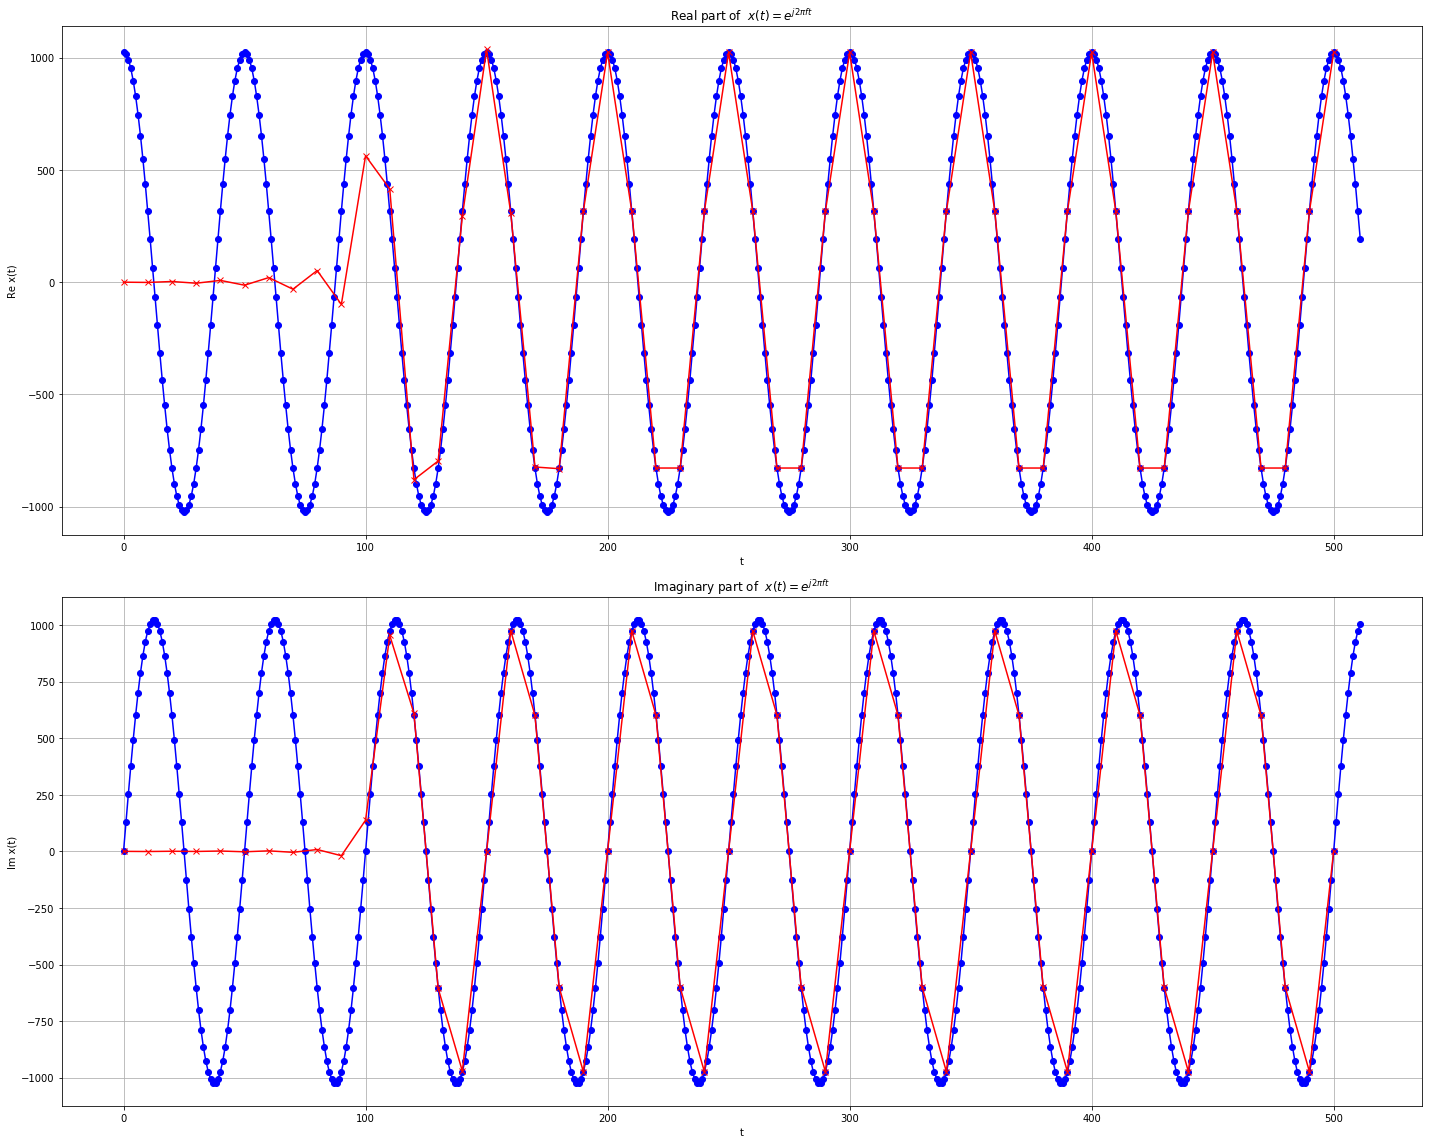

In [66]:
NUM_INPUT_SAMPLES_TO_PLOT = 512
if NUM_INPUT_SAMPLES_TO_PLOT > len(x):
    NUM_INPUT_SAMPLES_TO_PLOT = len(x)

NUM_OUTPUT_SAMPLES_TO_PLOT = int(NUM_INPUT_SAMPLES_TO_PLOT * p / q)

logging.info("Plotting %u input and %u output samples" % (NUM_INPUT_SAMPLES_TO_PLOT, NUM_OUTPUT_SAMPLES_TO_PLOT))

resampled_t = np.arange(0, len(y)) * q / p - filter_delay

plt.figure(figsize=(20, 16))
plt.subplot(2,1,1)
plt.plot(t[:NUM_INPUT_SAMPLES_TO_PLOT], x[:NUM_INPUT_SAMPLES_TO_PLOT].real, '-bo')
plt.plot(resampled_t[:NUM_OUTPUT_SAMPLES_TO_PLOT], y[:NUM_OUTPUT_SAMPLES_TO_PLOT].real, '-xr')
plt.xlabel('t')
plt.ylabel('Re x(t)')
plt.title(r'Real part of  $x(t)=e^{j 2 \pi f t}$');
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(t[:NUM_INPUT_SAMPLES_TO_PLOT], x[:NUM_INPUT_SAMPLES_TO_PLOT].imag, '-bo')
plt.plot(resampled_t[:NUM_OUTPUT_SAMPLES_TO_PLOT], y[:NUM_OUTPUT_SAMPLES_TO_PLOT].imag, '-xr')
plt.xlabel('t')
plt.ylabel('Im x(t)')
plt.title(r'Imaginary part of  $x(t)=e^{j 2 \pi f t}$');
plt.grid(True)

plt.tight_layout()
plt.show()

### Spectrogram Plot

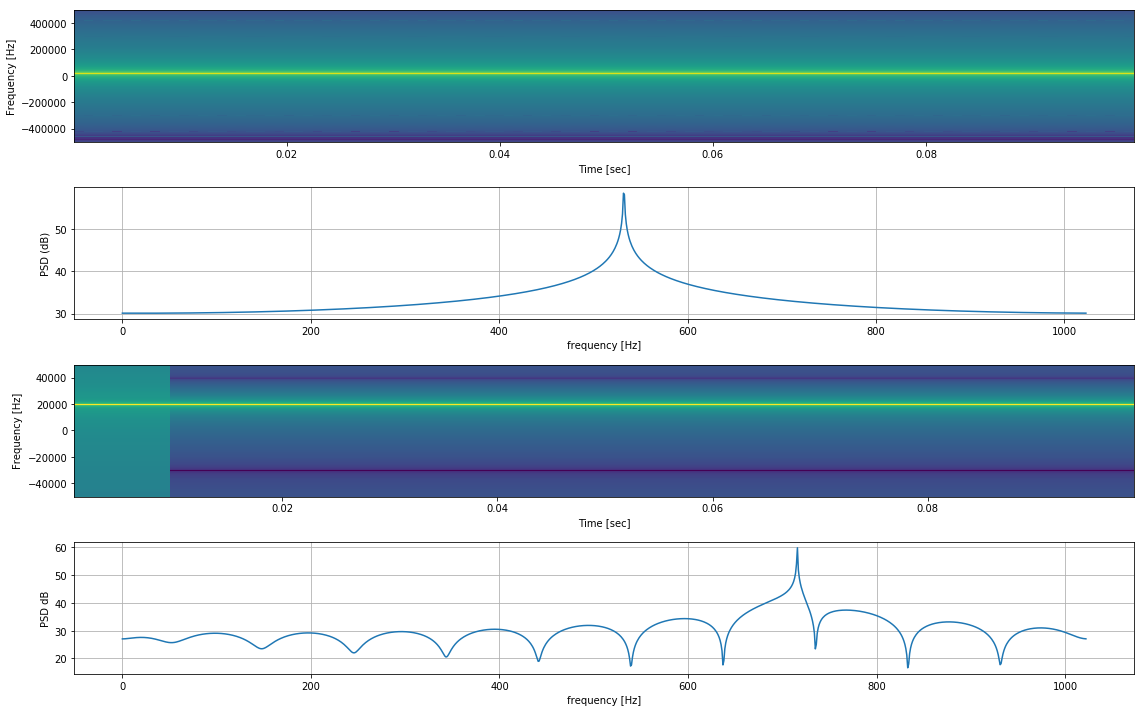

In [67]:
FFT_SIZE = 1024
plt.figure(figsize=(16, 10))

plt.subplot(4,1,1)
Pxx, freqs, bins, im = plt.specgram(x, NFFT=FFT_SIZE, Fs=INPUT_SAMPLE_RATE)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

plt.subplot(4,1,2)
f = np.abs(np.fft.fftshift(np.fft.fft(x, FFT_SIZE)))
f = 10 * np.log10(f)
plt.plot(f)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD (dB)')
plt.grid(True)

plt.subplot(4,1,3)
Pxx, freqs, bins, im = plt.specgram(y[filter_delay:], NFFT=FFT_SIZE, Fs=OUTPUT_SAMPLE_RATE)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

plt.subplot(4,1,4)
f = np.abs(np.fft.fftshift(np.fft.fft(y[filter_delay:], FFT_SIZE)))
f = 10 * np.log10(f)
plt.plot(f[1:])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD dB')
plt.grid(True)

plt.tight_layout()
plt.show()